# Sigmoid 量化

对于定义域 $\mathbb{R}$ 中的输入，sigmoid 函数将输入变换为区间 $(0, 1)$ 上的输出。因此，sigmoid 通常称为挤压函数（squashing function）：它将范围 $(- \infty, \infty)$ 中的任意输入压缩到区间 $(0, 1)$ 中的某个值，sigmoid 函数定义如下：

$$
\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}
$$

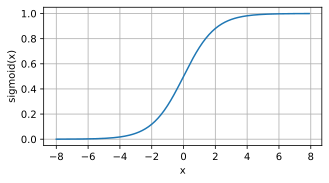

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch_book.vision.mp_plot import plot

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

sigmoid 函数特性：

$$
\operatorname{sigmoid}(x) + \operatorname{sigmoid}(-x) = 1
$$

sigmoid 函数的导数为下面的公式：

$$
\frac{\operatorname{d}}{\operatorname{d} x} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right) = \operatorname{sigmoid}(x)\operatorname{sigmoid}(-x)
$$

可视化导函数：

/home/xinet/.conda/envs/py38/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from current font.
  func(*args, **kwargs)
/home/xinet/.conda/envs/py38/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from current font.
  func(*args, **kwargs)
/home/xinet/.conda/envs/py38/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/home/xinet/.conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xinet/.conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from current font.
  fig.canvas.print_figure(bytes

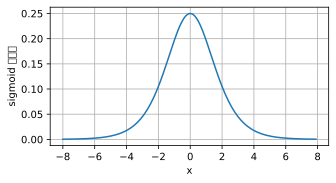

In [2]:
y.backward(torch.ones_like(x), retain_graph=True)
plot(x.detach(), x.grad, 'x', 'sigmoid 导函数', figsize=(5, 2.5))

sigmoid 函数的泰勒展示式：

$$
\operatorname{sigmoid}(x) = \operatorname{sigmoid}(x_0)( 1 + \operatorname{sigmoid}(-x_0) \sum_{k=1}^{\infty} \cfrac{(x - x_0)^k}{k!})
$$

## 区间分划

由于 sigmoid 函数关于 $y = 0.5$ 对称，故仅仅考虑 $x > 0$ 的部分即可。

由 sigmoid 及其导函数图像可以看出：$x \in [-6, 6]$ 的函数值以及导数值变化剧烈。依此可以将此范围外的函数值直接设定为极限值即可。

```{note}
对于 $n$ **分划**：

$$
\Delta: a=x_0 < x_1 < \cdots < x_n =b 
$$

在每个子段 $[x_i, x_{i+1}]$ 构造插值多项式，并将其拼接起来，即 **分段插值**。

若函数 $S_k(x)$ 在分划 $\delta$ 的每个子段 $[x_i, x_{i+1}]$ 都是 $k$ 次多项式，则称 $S_k(x)$ 为具有分划 $\delta$ 的 **分段 $k$ 次式**。点 $x_i$ （$i=0,1,\cdots,n$）称作 $S_k(x)$ 的节点。
```

为了提高量化精度，在 $[0, 6]$ 上考虑分段插值。取 $n=10$，依据 sigmoid 导函数的变化趋势可设定 $S_k(x)$ 的节点为：

In [3]:
nodes = 0, 0.25, 0.5, 0.75, 1, 2, 2.5, 3, 4, 5, 6
len(nodes)

11

In [4]:
x = torch.tensor(nodes, requires_grad=True)
y = torch.sigmoid(x)
y

tensor([0.5000, 0.5622, 0.6225, 0.6792, 0.7311, 0.8808, 0.9241, 0.9526, 0.9820,
        0.9933, 0.9975], grad_fn=<SigmoidBackward>)

In [5]:
y.backward(torch.ones_like(x), retain_graph=True)
x.grad

tensor([0.2500, 0.2461, 0.2350, 0.2179, 0.1966, 0.1050, 0.0701, 0.0452, 0.0177,
        0.0066, 0.0025])

## uint8 量化

先看看简单的方案：

In [6]:
def Qz(v, s):
    k = s * v - np.floor(v * s)
    o = k > 0.5
    return o.astype("int")

def Q(v, s):
    x = np.floor(v * s) + Qz(v, s)
    return x/s

In [7]:
scale = (1 << 8) -1
with torch.no_grad():
    qy = Q(y.numpy(), scale)
    qy = torch.from_numpy(qy)

In [8]:
from torch.ao.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver
observers = [MinMaxObserver(),
             MovingAverageMinMaxObserver(),
             HistogramObserver()]

ModuleNotFoundError: No module named 'torch.ao'

In [ ]:
for obs in observers:
    obs(y)
    print(obs.__class__.__name__, obs.calculate_qparams())

In [ ]:
(y/0.0039 + 0)/scale

In [ ]:
y

In [ ]:
qy

In [ ]:
print(obs)

In [ ]:
torch.per_tensor_affine